In [1]:
%matplotlib inline
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from pandas.tools.plotting import scatter_matrix

import matplotlib.mlab as mlab

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from scipy.stats import sem

In [2]:
data = pd.read_csv('student_vector_new_29_10_2015.csv')

In [ ]:
data.columns

In [ ]:
data.head()

In [3]:
data['physics_true'] = [1 if x==3 else 0 for x in data['graduated_category']]

In [ ]:
data.head()

In [ ]:
data.groupby('physics_true').count()

In [4]:
data['is_train'] = np.random.uniform(0, 1, len(data)) <= 0.75

In [5]:
data.head()

,PlaceholderID,gndr_flag,Ethnicity,first_gen,graduated_category,pre-major class level,lower_math_count,lower_math_dist_count,lower_math_course_attempt_ratio,lower_math_avg,...,lower_physics_course_attempt_ratio,lower_physics_avg,lower_physics_std,upper_physics_dist_count,upper_physics_course_attempt_ratio,upper_physics_count,upper_physics_avg,upper_physics_std,physics_true,is_train
0,000A5CF0-0DBA-48BD-B7C1-982BBDFFF40B,0,7,0,1,1,8,5,0.625000,0.375000,...,0.800000,0.450000,0.287772,4,0.800000,1,0.375,0.000000,0,False
1,002E1739-81FA-467D-91A6-2318A00273E3,0,7,0,4,1,2,2,1.000000,0.562500,...,1.000000,0.833333,0.072169,3,1.000000,0,0.000,0.000000,0,True
2,004E919F-6AD9-4F34-B4DC-19328B9FBF1F,0,7,0,4,1,9,5,0.555556,0.347222,...,0.833333,0.562500,0.233854,5,0.833333,9,0.500,0.197642,0,False
3,0082B136-3401-4D35-AE45-494A67111358,0,7,0,4,3,0,0,0.000000,0.000000,...,1.000000,0.625000,0.000000,1,1.000000,0,0.000,0.000000,0,True
4,00A6E8CF-9302-4C7D-83BA-DC5DDA31E543,0,7,0,2,0,4,3,0.750000,0.531250,...,0.000000,0.000000,0.000000,0,0.000000,0,0.000,0.000000,0,False


In [6]:
train, test = data[data['is_train']==True], data[data['is_train']==False]

In [20]:
train.groupby('physics_true').count()

,PlaceholderID,gndr_flag,Ethnicity,first_gen,graduated_category,pre-major class level,lower_math_count,lower_math_dist_count,lower_math_course_attempt_ratio,lower_math_avg,...,lower_physics_dist_count,lower_physics_course_attempt_ratio,lower_physics_avg,lower_physics_std,upper_physics_dist_count,upper_physics_course_attempt_ratio,upper_physics_count,upper_physics_avg,upper_physics_std,is_train
physics_true,,,,,,,,,,,,,,,,,,,,,
0,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,...,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309
1,304,304,304,304,304,304,304,304,304,304,...,304,304,304,304,304,304,304,304,304,304


## Force a bootstrap on the training data
There is a problem with false predictions when there's a significant imbalance between classes that you are trying to classify. So, I forced a bootstrap by randomly selecting more records from students with physics degrees until there's roughly equal number of students earning physics and nonphysics degrees are represented in the training data.

In [70]:
## force a bootstrap; randomly select more records from students with physics degrees to interrogate sampling issues
bootstrap_train = train
for i in range(0,7):
    bootstrap_train = pd.concat([bootstrap_train,train[train['physics_true'] == 1].sample(frac=0.5)])

In [ ]:
# features = ['gndr_flag', 'Ethnicity', 'first_gen','pre-major class level',
#             'lower_math_course_attempt_ratio', 'lower_physics_course_attempt_ratio',
#        'lower_physics_avg','lower_math_avg']

In [71]:
bootstrap_train.groupby('physics_true').count()

,PlaceholderID,gndr_flag,Ethnicity,first_gen,graduated_category,pre-major class level,lower_math_count,lower_math_dist_count,lower_math_course_attempt_ratio,lower_math_avg,...,lower_physics_dist_count,lower_physics_course_attempt_ratio,lower_physics_avg,lower_physics_std,upper_physics_dist_count,upper_physics_course_attempt_ratio,upper_physics_count,upper_physics_avg,upper_physics_std,is_train
physics_true,,,,,,,,,,,,,,,,,,,,,
0,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,...,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309
1,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,...,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368


In [72]:
# features = ['gndr_flag', 'Ethnicity', 'first_gen',
#         'pre-major class level',
#        'lower_math_dist_count', 
#        'lower_math_avg',  
#        'lower_physics_dist_count', 
#        'lower_physics_avg', ]

In [73]:
features = ['gndr_flag', 'Ethnicity', 'first_gen',
        'pre-major class level',
       'lower_math_dist_count',
       'lower_math_avg', 
       'lower_physics_dist_count', 
       'lower_physics_avg']

In [74]:
feature_we_are_trying_to_predict = 'physics_true'
#feature_we_are_trying_to_predict = 'graduated_category'
class_names = ['!Earn PA Degree','Earn PA Degree']

In [75]:
y = pd.factorize(bootstrap_train[feature_we_are_trying_to_predict])[0]
y_test = pd.factorize(test[feature_we_are_trying_to_predict])[0]
X = bootstrap_train[features]
X_test = test[features]

In [76]:
# Scaling to ensure it doesn't behave badly
scaler = StandardScaler()
scaler.fit(X)

# Now apply the transformations to the data:
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [77]:
# Create a random forest classifier. By convention, clf means 'classifier'

## There was definitely a problem with imbalance. You have 4 times as many people not graduating with physics degrees
## I increased the number of trees in the forest as well

clf = RandomForestClassifier(n_estimators = 1024, criterion = 'entropy', n_jobs = -1);

# Train the classifier to take the training features, X, and learn how they relate
# to the training classes, y
clf.fit(X, y);

# Apply the classifier we trained to the test data (which, remember, it has never seen before)
pred_y_test = clf.predict(X_test);

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
stderr = sem([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

In [78]:
## Confusion Matrix
cnf_matrix = confusion_matrix(y_test,pred_y_test)
print('Confusion Matrix:\n',cnf_matrix)

## Check accuracy of model on test data
acc_score = accuracy_score(y_test, pred_y_test);
print('Percentage of accurate predictions:\n', acc_score)

## Compute predicted class probabilities
preds = clf.predict_proba(X_test)

## Determine false positive and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])

## Store rates for plotting
dfROC = pd.DataFrame(dict(fpr = fpr, tpr = tpr))

## Compute area under curve of ROC
area_under_curve = auc(fpr,tpr)
print('Area under curve:\n', area_under_curve)

Confusion Matrix:
 [[361  47]
 [ 36  54]]
Percentage of accurate predictions:
 0.833333333333
Area under curve:
 0.873897058824


In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[361  47]
 [ 36  54]]
Normalized confusion matrix
[[ 0.88480392  0.11519608]
 [ 0.4         0.6       ]]


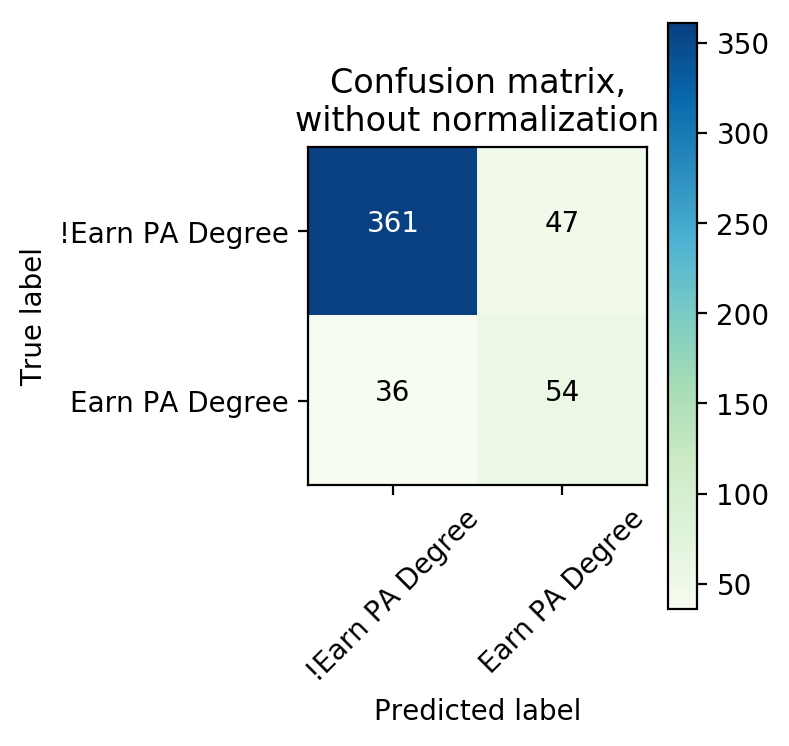

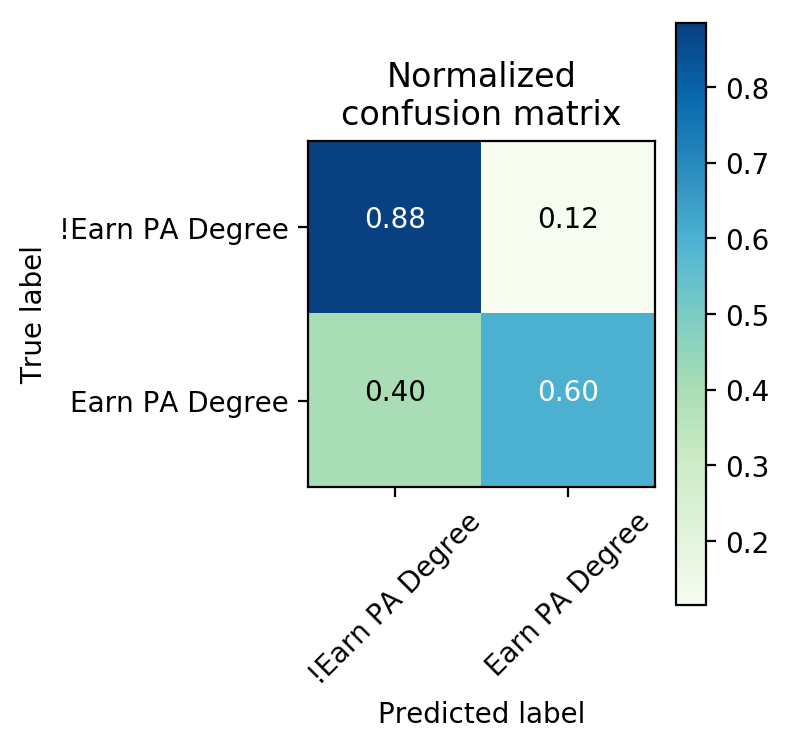

In [80]:
# Plot non-normalized confusion matrix
plt.figure(figsize = (4,4), dpi = 200)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix,\nwithout normalization')
plt.tight_layout()

# Plot normalized confusion matrix
plt.figure(figsize = (4,4), dpi = 200)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized\nconfusion matrix')
plt.tight_layout()

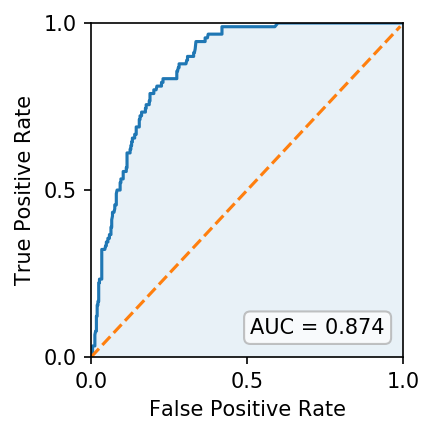

In [81]:
#just to plot guessing line
a = np.arange(0,1,0.01)

bboxprops = {'facecolor':'white', 'pad':0.3, 'boxstyle':'round', 'edgecolor':'darkgrey', 'alpha':0.7}

fig1 = plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

plt.plot(dfROC['fpr'],dfROC['tpr'],'-')
plt.plot(a,a,'--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax1.fill_between(dfROC['fpr'], 0, dfROC['tpr'],alpha=0.1)
ax1.text(0.51, 0.07, 'AUC = '+ str(round(area_under_curve, 3)), bbox = bboxprops)
plt.axis([0,1,0,1])
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])

plt.tight_layout()

In [82]:
print(clf.score(test[features],test[feature_we_are_trying_to_predict]));

0.285140562249


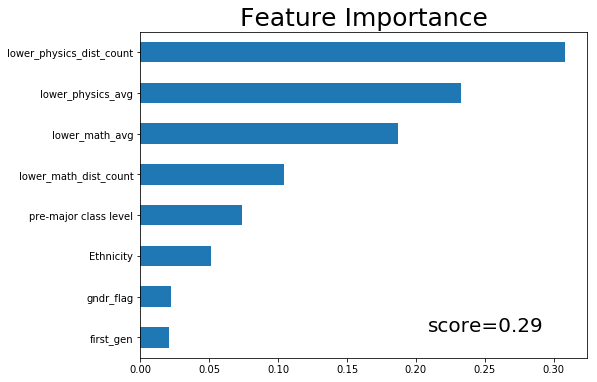

In [83]:
feature_importance = sorted(zip(clf.feature_importances_, features))
feature_importance = pd.DataFrame(feature_importance, columns=['value', 'feature'])
feature_importance = feature_importance.set_index('feature')
ax = feature_importance.plot(kind='barh', legend=False, figsize=((8,6)))
ax.set_ylabel('')
ax.set_title('Feature Importance', fontsize=25)
ax.text(feature_importance.max()[0]-0.1,0.15,s='score={s}'.format(s=round(clf.score(test[features],test[feature_we_are_trying_to_predict]),2))
       ,fontsize=20)

In [ ]:
# # Create a selector object that will use the random forest classifier to identify
# # features that have an importance of more than 0.15
# sfm = SelectFromModel(clf, threshold=0.05)

# # Train the selector
# sfm.fit(X, y)

In [ ]:
# test_data = data[data['is_train']==False][feature_we_are_trying_to_predict]

In [ ]:
# clf = RandomForestClassifier(n_estimators=128)

In [ ]:
# clf.fit(train[features], y)

In [ ]:
# prediction = clf.predict(test[features])

In [ ]:
# score_data = (abs(prediction - test_data))

In [ ]:
# score_data.hist(normed=True)

In [ ]:
# clf.predict_proba(test[features])

In [ ]:
clf.score(test[features],test[feature_we_are_trying_to_predict])

In [ ]:
# feature_importance = sorted(zip(clf.feature_importances_, features))

In [ ]:
# feature_importance = pd.DataFrame(feature_importance)

In [ ]:
# feature_importance.columns = ['importance', 'feature']

In [ ]:
# feature_importance.index = feature_importance.feature

In [ ]:
color=['red','blue','blue','blue','blue','blue','blue','blue']

In [ ]:
feature_importance.max()[0]

In [ ]:
feature_importance = sorted(zip(clf.feature_importances_, features))
ax = feature_importance.plot(kind='barh', legend=False, figsize=((8,6)))
ax.set_ylabel('')
ax.set_title('Feature Importance', fontsize=25)
ax.text(feature_importance.max()[0]-0.1,0.15,s='score={s}'.format(s=round(clf.score(test[features],test[feature_we_are_trying_to_predict]),2))
       ,fontsize=20)

In [ ]:
prediction.shape

In [ ]:
y.shape

In [ ]:
train_test_split(train,test)

In [ ]:
## Confusion Matrix
# confusion = confusion_matrix(y_test,pred_y_test)
confusion = confusion_matrix(y, prediction)
print('Confusion Matrix:\n',confusion)

In [ ]:
## Check accuracy of model on test data
acc_score = accuracy_score(y_test, pred_y_test);
print('Percentage of accurate predictions:\n', acc_score)

## Compute predicted class probabilities
preds = clf.predict_proba(X_test)

## Determine false positive and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])

## Store rates for plotting
dfROC = pd.DataFrame(dict(fpr = fpr, tpr = tpr))

## Compute area under curve of ROC
area_under_curve = auc(fpr,tpr)
print('Area under curve:\n', area_under_curve)

In [ ]:
color = []
for d in data[feature_we_are_trying_to_predict]:
    if d==True:
        color.append('red')
    else:
        color.append('gray')

In [ ]:
def add_jitter(df, jitter):
    """
    Adds jitter to a data set based on a random normal
    distribution.
    
    Requirements: numpy, pandas
    """
    return abs(df + np.random.normal(df, jitter, size=len(df)))

In [ ]:
scatter_matrix(data[features], color=color, figsize=(20,20), alpha=0.5)

In [ ]:
from sklearn import svm, datasets


In [ ]:
iris = datasets.load_iris()

In [ ]:
iris.data.shape

In [ ]:
iris.target.shape

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

train, test = df[df['is_train']==True], df[df['is_train']==False]

features = df.columns[:4]
clf = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['species'])
clf.fit(train[features], y)

preds = iris.target_names[clf.predict(test[features])]
pd.crosstab(test['species'], preds, rownames=['actual'], colnames=['preds'])

In [ ]:
df.groupby('is_train').count()